## import packages

In [174]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib qt
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images
extract object points and image points for camera calibration

In [31]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# need (1) the number of inside corners in x and (2) the number of inside corners in y
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space.  ex:array([[ 0.,  0.,  0.],[ 1.,  0.,  0.],[ 2.,  0.,  0.],[ 3.,  0.,  0.],

imgpoints = [] # 2d points in image plane. ex: [array([[[ 545.32281494,  343.05032349]],[[ 602.67919922,  342.82681274]], 

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    new_fname = "..//calibrated_img_chessboard//marked_"+ fname.split("\\")[-1]
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imsave(fname = new_fname, arr =img )
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

In [37]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{url}' />" for url in urls])

    display(HTML(images_list))

In [6]:
display_category(images, "")

In [52]:
def read_pickle(f_path):
    with open(f_path, 'rb') as handle:
        return pickle.load(handle)

def write_pickle(f_path, data):
    with open(f_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
matrix_data_path = "..//matrix_data//chessboard_calibrationPoint.p"

In [53]:
chessboard_calibrationPoint = {"objpoints": objpoints, "imgpoints": imgpoints}
write_pickle(matrix_data_path, chessboard_calibrationPoint)

In [55]:
# Read in the saved objpoints and imgpoints
dist_pickle = read_pickle(matrix_data_path)
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

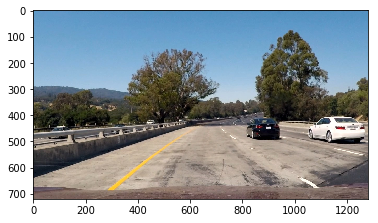

In [71]:
test_img_path = "..//test_images"
img = cv2.imread(os.path.join(test_img_path, 'test1.jpg'))  
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(RGB_img)

## Get undistorted image

input: distorted image 
output: undistorted image

* Undistort the image using cv2.undistort() with mtx and dist
* Define 4 source points (the outer 4 corners detected in the chessboard pattern)
* Define 4 destination points (must be listed in the same order as src points!)
* Use cv2.getPerspectiveTransform() to get M, the transform matrix
* use cv2.warpPerspective() to apply M and warp your image to a top-down view

ret:1.0298149716172824


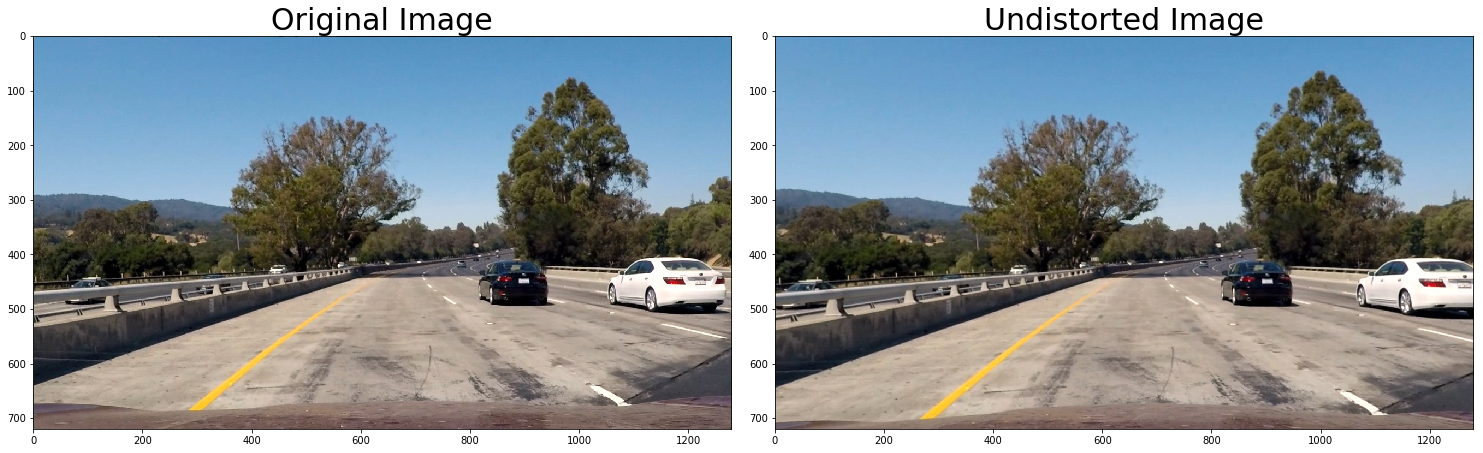

In [268]:
def cal_undistort(img, objpoints, imgpoints):
    """
    1. read an image, object points, and image points
    2. performs the camera calibration, image distortion correction
    3. returns the undistorted image
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    img_corner = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print ("ret:" + str(ret))
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Save the camera calibration result for later use (Ignore about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    write_pickle("..//matrix_data//wide_dist_pickle.p", dist_pickle)

    return undist

cp_img = np.copy(img)
RGB_img = cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB)

undistorted= cal_undistort(cp_img, objpoints, imgpoints)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(RGB_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [86]:
## perspective transform

In [282]:
#perspective transform on undistorted images
def perspective_transform(img):
    # Minv: inverse matrix
    size_y, size_x, _ = img.shape
    img_size = (size_x, size_y) 
    
    color_selector_obj = laneLineDetector()
    cp_img = np.copy(img)
    out_image = color_selector_obj.color_filterprocess_image(cp_img)
    src = color_selector_obj.src_pts
    
#     src = np.float32([[(.55*size_x, 0.63*size_y)
#                      , (size_x,size_y)
#                      , (0,size_y)
#                      ,(.45*size_x, 0.63*size_y)]])


    # the order is (1)upper left (2)upper right (3) lower right (4) lower left
    dst = np.float32([[0.25*size_x,0]
                     , [0.75*size_x,0]         
                    ,[0.75*size_x,size_y]
                    ,[0.25*size_x,size_y]])
    
    # draw region of interest
    src_img = draw_polygon(img, np.int32(src))
    dst_img = draw_polygon(img, np.int32(dst))
    
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    perspective_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)    
    return perspective_img, Minv, src_img, dst_img

#region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

origin -> undistorted -> perspective image

In [283]:
perspective_img, Minv, s_img, t_img = perspective_transform(undistorted)

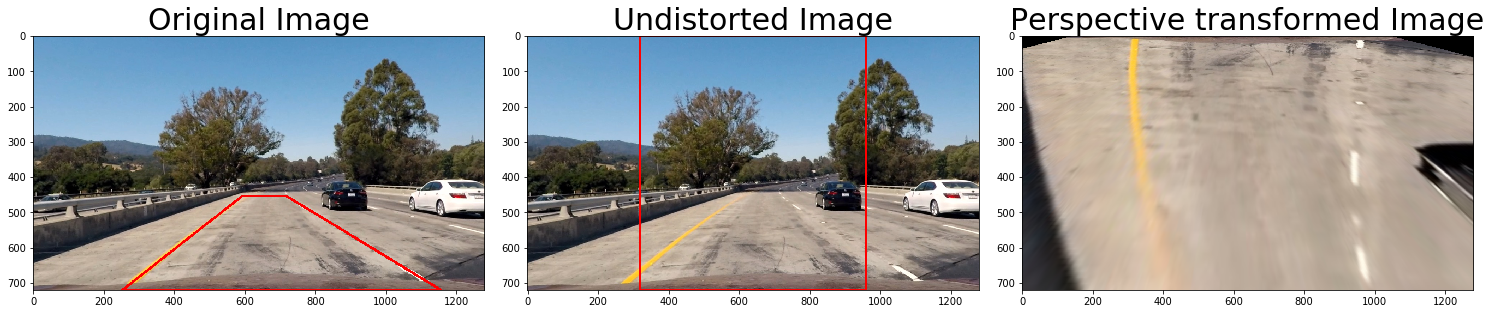

In [284]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
f.tight_layout()
ax1.imshow(s_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(t_img)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(perspective_img)
ax3.set_title('Perspective transformed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

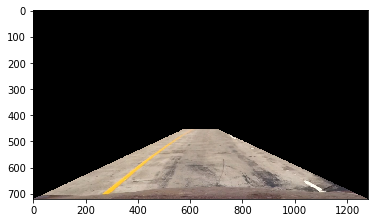

In [176]:
size_y, size_x, _ = undistorted.shape
img_size = (size_x, size_y) 

masked_img = region_of_interest(undistorted
                 , np.int32([[(.55*size_x, 0.63*size_y)
                 , (size_x,size_y)
                 , (0,size_y)
                 ,(.45*size_x, 0.63*size_y)]]))
plt.imshow(masked_img)

In [311]:
## Contrast image

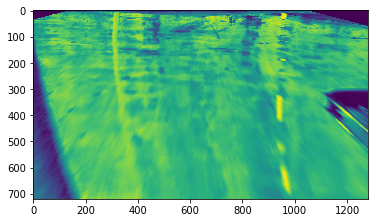

In [312]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
contrast_img = clahe.apply(cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY))
plt.imshow(contrast_img)

In [319]:
sobely = cv2.Sobel(contrast_img, cv2.CV_64F, 0, 1)
sobelx = cv2.Sobel(contrast_img, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

In [ ]:
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

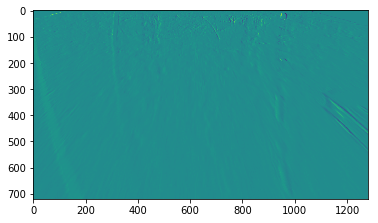

In [314]:
plt.imshow(sobelx)

error: D:\Build\OpenCV\opencv-3.3.1\modules\imgproc\src\clahe.cpp:360: error: (-215) _src.type() == (((0) & ((1 << 3) - 1)) + (((1)-1) << 3)) || _src.type() == (((2) & ((1 << 3) - 1)) + (((1)-1) << 3)) in function `anonymous-namespace'::CLAHE_Impl::apply


In [293]:
perspective_img.shape
    new_fname = "..//contrast_enhanced_images//tileGridSize_"+ str(i)+".jpg"
    plt.imsave(fname = new_fname, arr =img ) 

(720, 1280, 3)

In [277]:
gray = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY)

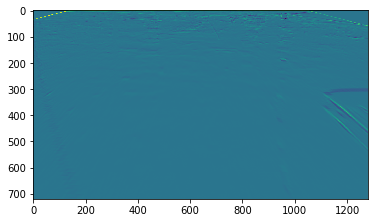

## Test functions

In [150]:
def draw_polygon(img, pts, color = (255, 0, 0), thickness = 5):
    cp_img = np.copy(img)
    cv2.polylines(cp_img, [pts], True, color, thickness)
    return cp_img

In [124]:
def draw_circles(img, pts, radius = 20, color = [255, 0, 0], thickness = 5):
    cp_img = np.copy(img)
    for x,y in pts:
        cv2.circle(cp_img, (x,y), radius, color, thickness)
    return cp_img

In [148]:
imshape = img.shape
vertices = np.array([(.6*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0]),
                   (0,imshape[0]),(.4*imshape[1], 0.6*imshape[0])], dtype=np.int32)

In [ ]:
top_down, M = perspective_transform(img)

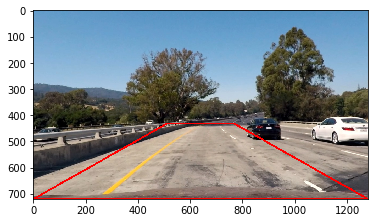

In [151]:
a= draw_polygon(undistorted, vertices)
plt.imshow(a)

[ 576.         453.6000061]
[ 576.         453.6000061]
[ 576.         453.6000061]
[ 576.         453.6000061]


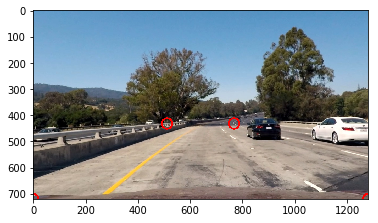

In [127]:
imshape = undistorted.shape
a= draw_circles(undistorted, vertices)
plt.imshow(a)

In [128]:
pts = np.array([[2, img.shape[0]-10], [img.shape[1]-5, img.shape[0]-10], [.55*img.shape[1], 0.625*img.shape[0]], [.45*img.shape[1], 0.625*img.shape[0]]], np.int32)
# cv2.polylines(img, [pts], True, (0,255,255), 3)

In [129]:
pts.shape

(4, 2)

In [250]:
class laneLineDetector:
    def __init__(self):
        """
        parameter for image processing
        """
        self.houghLine_para = { "rho": 1
                               , "theta": np.pi/180
                               , "threshold": 50
                               , "min_line_len": 100
                               , "max_line_gap": 160}

        self.canny_para = { "low_threshold": 50
                           , "high_threshold": 200}
        self.gaussian_blur_para = { "kernel_size": 7}
        
        """
        parameter from hough line filter
        """
        self.left_slope_upperbound = -0.2
        self.left_slope_lowerbound = -10.0

        self.right_slope_upperbound = 10.0
        self.right_slope_lowerbound = 0.2
        
        self.left_distance_upperbound = 300.0
        self.left_distance_lowerbound = 20.0 
        
        self.right_distance_upperbound = 300.0
        self.right_distance_lowerbound = 20.0
        
        """
        parameters for color filter
        """
        self.yellowLine_color_boundary = ([200,170,0], [255, 225, 150])
        self.WhiteLine_color_boundary = ([210,210,210], [255, 255, 255])

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        Generating Hough Lines for lane line detection 
        """        
        # The first and second row are the coordinates of left point. 
        # The first one is x_left, and the second one is y_left.
        # The third and fourth row are the coordinates of right point. 
        # The third one is x_right, and the fourth one is y_right.
        return np.squeeze(cv2.HoughLinesP(img, rho, theta
                                          , threshold, np.array([])
                                          , minLineLength=min_line_len
                                          , maxLineGap=max_line_gap), axis=1)

    def line_extrapolation(self):
        # compute line slope
        left_slope = np.divide(self.left_lines[1] - self.left_lines[3]
                               , self.left_lines[0] - self.left_lines[2])
        right_slope = np.divide(self.right_lines[1] - self.right_lines[3]
                                , self.right_lines[0] - self.right_lines[2])
                
        # capture fitting lane lines based on the slope average of Hough lines
        # do lane line extrapolation 
        Lane_Y_lowerbound = int(self.img.shape[0] * 0.63)
        Lane_Y_upperbound = self.img.shape[0]

        # the weight is the square of line length
        left_weight = np.sqrt(np.sum(np.square([self.left_lines[1] - self.left_lines[3]
                                                , self.left_lines[0] - self.left_lines[2]]), axis = 0))
        right_weight = np.sqrt(np.sum(np.square([self.right_lines[1] - self.right_lines[3]
                                                 , self.right_lines[0] - self.right_lines[2]]), axis = 0))
        
        left_weighted_slope = np.sum(left_weight * left_slope) / np.sum(left_weight)
        right_weighted_slope = np.sum(right_weight * right_slope) / np.sum(right_weight)

        left_masscenter = left_weight * self.left_lines
        right_masscenter = right_weight * self.right_lines
        
        # Assume mass center is (a,b) 
        # line formula: y-b = m * (x - a), m is slope
        # substitute Lane_Y_lowerbound, Lane_Y_upperbound into the equations 
        # and get Lane_X_lowerbound, Lane_X_upperbound
        
        left_weighted_masscenter = np.sum( np.stack((left_masscenter[0]+left_masscenter[2]
                                                     , left_masscenter[1]+left_masscenter[3])
                                                    , axis=0), axis=1) / (np.sum(left_weight, axis=0)* 2)
        right_weighted_masscenter = np.sum( np.stack((right_masscenter[0]+right_masscenter[2]
                                                      , right_masscenter[1]+right_masscenter[3])
                                                     , axis=0), axis=1) / (np.sum(right_weight, axis=0)* 2)
        
        # x = (y-b)/m + a
        return [((Lane_Y_upperbound - left_weighted_masscenter[1]) / left_weighted_slope 
                 + left_weighted_masscenter[0]
                 , Lane_Y_upperbound) # left_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - left_weighted_masscenter[1]) / left_weighted_slope 
                   + left_weighted_masscenter[0]
                   , Lane_Y_lowerbound)  # left_Lane_X_lowerbound
                 ,((Lane_Y_upperbound - right_weighted_masscenter[1]) / right_weighted_slope 
                   + right_weighted_masscenter[0]
                   , Lane_Y_upperbound)  # right_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - right_weighted_masscenter[1]) / right_weighted_slope 
                   + right_weighted_masscenter[0]
                   , Lane_Y_lowerbound)] # right_Lane_X_lowerbound
    
    def hough_line_filter(self, lines, distance_ftr = False):

        # calculate the slope and length of the lines for visualization
        self.slope = np.divide(lines[1]-lines[3], lines[0]-lines[2])
        right_condition = (self.slope >= self.right_slope_lowerbound)\
                            & (self.slope < self.right_slope_upperbound)
        left_condition = (self.slope >= self.left_slope_lowerbound)\
                            & (self.slope < self.left_slope_upperbound)
        
        """
        remove the lines which are too close to the region-of-interest boundary. 
        """
        if distance_ftr:
            left_vec_diff = self.reference_points_left[0] - self.reference_points_left[1]
            right_vec_diff= self.reference_points_right[0] - self.reference_points_right[1]        

            # Each line segment has two points, P1 and P2. 
            # The distance of the line to the boundary is 
            # the average of distance between P1 and boundary, P2 and boundary 
            P1 = lines[:2,:].T
            P2 = lines[2:4, :].T
            
            # if the slope is positive, the distance is P1 to right boundary. 
            # If negative, he distance is P1 to left boundary 
            distance_to_P1 = np.where( self.slope >=.0
                             , np.abs(np.cross(P1 - self.reference_points_right[0]
                                            , right_vec_diff)) / self.reference_points_distance
                             , np.abs(np.cross(P1 - self.reference_points_left[0]
                                            , left_vec_diff)) / self.reference_points_distance)

            # if the slope is positive, the distance is P2 to right boundary. 
            # if negative, he distance is P1 to left boundary 
            distance_to_P2 = np.where( self.slope >=.0
                             , np.abs(np.cross(P2 - self.reference_points_right[0]
                                            , right_vec_diff)) / self.reference_points_distance 
                             , np.abs(np.cross(P2 - self.reference_points_left[0]
                                            , left_vec_diff)) / self.reference_points_distance) 
            self.distance = (distance_to_P1 + distance_to_P2)/2
            
            # to know which side that line is located
            P1_Y = lines[1,:]     
            P1_X = lines[0,:]
            P2_Y = lines[3,:]    
            P2_X = lines[2,:]        
            
            side_of_P1 = np.where( self.slope >=.0
                             , P1_Y - self.reference_points_right[0][1] 
                                      - self.slope * (P1_X - self.reference_points_right[0][0])
                             , P1_Y - self.reference_points_left[0][1] 
                                      - self.slope * (P1_X - self.reference_points_left[0][0]))
            
            side_of_P2 = np.where( self.slope >=.0
                             , P2_Y - self.reference_points_right[0][1]
                                      - self.slope * (P2_X - self.reference_points_right[0][0])
                             , P2_Y - self.reference_points_left[0][1]
                                      - self.slope * (P2_X - self.reference_points_left[0][0]))
            
            
            right_condition = right_condition & ((side_of_P1 > 0) 
                                                 & (side_of_P2 > 0))
            left_condition = left_condition & ((side_of_P1 > 0) 
                                                 & (side_of_P2 > 0))
            
            right_condition = right_condition & ((self.distance >= self.right_distance_lowerbound) 
                                                 & (self.distance < self.right_distance_upperbound))
            left_condition = left_condition & ((self.distance >= self.left_distance_lowerbound) 
                                               & (self.distance < self.left_distance_upperbound))
        
        # there are two filters: 
        # filter based on slope and filter based on distance between 
        # detected Hough lines and boundaries. 
        
        # right lines filters: 
        self.right_lines = (lines[:,np.array(right_condition)])

        # left lines filter: 
        self.left_lines = (lines[:,np.array(left_condition)])
        
        # if no line was picked after filtering, 
        # then pick line of the smallest slope for left line 
        # and line of the largest slope for right line
        if self.left_lines.shape[1] == 0:
            self.left_lines = lines[:,np.argmin(self.slope)].reshape(4,1)    
        if self.right_lines.shape[1] == 0:
            self.right_lines = lines[:,np.argmax(self.slope)].reshape(4,1)

        return self.right_lines, self.left_lines

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def weighted_img(self, initial_img, img, α=1.0, β=0.8, λ=0.):
        """
        initial_img * α + img * β + λ
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    def get_fitLineCharacter(self, x, y):
        """
        format is y = slope * x + intercept
        """
        slope, intercept, _, _, std_err = stats.linregress(x,y)
        return slope, intercept

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=10):
        for x1, y1, x2, y2 in lines:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    def draw_circle(self, img, center, radius, color, thickness = 5):
        cv2.circle(img, center, radius, color, thickness)

    def draw_triangle(self, img, vertex, color, thickness = 5):
        cv2.polylines(img, [vertex], True, color,thickness)
        
    def viz_line_features(self):
        """
        visualize the distribution of Hough line features
        """
        line_num = self.slope.shape[0]
        
        self.slope = np.reshape(self.slope, (1, line_num))
        self.distance = np.reshape(self.distance, (1, line_num))
            
        input_scatterPlot = np.concatenate((self.slope.T
                                            , self.distance.T), axis=1)    
        
        dataframe = pd.DataFrame(input_scatterPlot, columns=['Slope', 'Distance'])

        dataframe['lineSign'] = pd.Series(np.squeeze(np.where(self.slope >=.0
                                                              , 'right'
                                                              , 'left'), axis=0))
        fig = ff.create_scatterplotmatrix(dataframe
                                          , diag='histogram'
                                          , index='lineSign'
                                          , height=800, width=800)
        plotly.offline.iplot(fig, filename='Box plots along Diagonal Subplots')

    def point_to_line_distance(self, A, B, P):
        """ 
        segment line AB, point P, where each one is an array([x, y]) 
        the angle lies in [-pi/2, pi/2].
        """
        if (A==B).all():
            return norm(P - A)
        else :
            return abs(np.cross(P - B, A - B) / norm(A - B))

    def show_img(self, img):
        cv2.namedWindow("Image")   
        cv2.imshow("Image", img)
        cv2.waitKey (0)  
        cv2.destroyAllWindows()  

    def color_of_interest(self, img, boundary):
        lower, upper = boundary
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply
        # the mask
        mask = cv2.inRange(img, lower, upper)
        return cv2.bitwise_and(img, self.img,  mask= mask)
        
    def plot_color_distribution(self, elements, color, _alpha = 0.5, _size = 5, _dpi = 96, dim ='RB'):

        color_dict = {'R':0, 'G':1, 'B':2}
        color1 = color_dict[dim[0]]
        color2 = color_dict[dim[1]]

        plt.figure(figsize=(500/_dpi, 500/_dpi), dpi=_dpi)
        plt.axis([0, 1, 0, 1])
        plt.axes([0.0, 0.0, 1, 1])
        plt.scatter(elements[:,color1],elements[:,color2], s=_size, c=color, alpha=_alpha)
        
        plt.xlabel(dim[0])
        plt.ylabel(dim[1])
        plt.title(dim + ' distribution')

        plt.xlim(min(elements[:,color1]), max(elements[:,color1]))
        plt.ylim(min(elements[:,color2]), max(elements[:,color2]))
        
        plt.savefig('color_distribution//'+dim+'_distribution.png')
        return
           
    def color_filterprocess_image(self, img):
        """
        the main pipeline for lane line detection
        """
        self.img = img
        self.img_size = img.shape

        
        # points for calculating the point-to-line distance
        # np.array([[480, 270], [960, 540]])
        self.reference_points_right = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                                , [self.img_size[1], self.img_size[0]]])        
        # np.array([[480, 270], [0, 540]])   
        self.reference_points_left = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                               , [0 ,self.img_size[0]]])                                      
        self.reference_points_distance = norm(self.reference_points_right[0] 
                                              - self.reference_points_right[1])   
        
        
        # points for fetching region of interest
        self.auxiliary_points = np.array([[(0,self.img_size[0])
                                           ,(self.img_size[1]//2, self.img_size[0]//2)
                                           , (self.img_size[1],self.img_size[0])]], dtype=np.int32)
        
        # capture the region of interest
        self.masked_img = self.region_of_interest(self.img, self.auxiliary_points)
        
        # tranform image from (height, width, 3) to (height * width, 3)
        self.non_black_elements = self.masked_img[self.masked_img.any(axis=-1)]  
        self.color = self.non_black_elements/255
        self.yellowLine_img = self.color_of_interest(self.masked_img, self.yellowLine_color_boundary)
        self.whiteLine_img = self.color_of_interest(self.masked_img, self.WhiteLine_color_boundary)
        
        self.blend_img = self.weighted_img(self.yellowLine_img, self.whiteLine_img)        
        
        # output an image with only one color channel
        self.gray_image = self.grayscale(self.blend_img)
#         self.sharpened_img = np.where(self.gray_image > 0, 255, 0) 
        
        # canny transformation
        self.canny_img = self.canny(self.gray_image
                                    , self.canny_para["low_threshold"]
                                    , self.canny_para["high_threshold"])
        
        # filter for Gaussian smoothing 
        self.gaussian_blur_para = { "kernel_size": 5}
        self.blurred_img = self.gaussian_blur(self.canny_img, self.gaussian_blur_para["kernel_size"])

        # hough line generation
        self.houghLines = self.hough_lines(self.blurred_img
                                   , self.houghLine_para["rho"]
                                   , self.houghLine_para["theta"]
                                   , self.houghLine_para["threshold"]
                                   , self.houghLine_para["min_line_len"]
                                   , self.houghLine_para["max_line_gap"]) 
        
        # separate Hough lines into left lines and right lines. 
        # search (1) the leftmost point of right Hough lines and 
        # (2) the rightmost point of left Hough lines
        self.right_lines, self.left_lines = self.hough_line_filter(self.houghLines.T,True)
        [(left_upper_x1,left_upper_y1)
         , (left_lower_x1,left_lower_y1)
         , (right_upper_x1,right_upper_y1)
         , (right_lower_x1,right_lower_y1)] = self.line_extrapolation()
        
        # source points for perspective transformation
        self.src_pts = np.array([(left_upper_x1,left_upper_y1)
                        , (right_upper_x1,right_upper_y1)
                        , (right_lower_x1,right_lower_y1)
                        , (left_lower_x1,left_lower_y1)], dtype=np.float32)
        
        # draw lane lines after extrapolation 
        out_img = np.copy(self.img)
        self.draw_lines(out_img
                        , [[left_upper_x1,left_upper_y1, left_lower_x1,left_lower_y1]
                        ,[right_upper_x1,right_upper_y1, right_lower_x1,right_lower_y1]]
                        ,color=[255, 0, 0]
                        , thickness=10)

        return out_img

In [241]:
from numpy.linalg import det, norm

In [242]:
color_selector_obj = laneLineDetector()
cp_img = np.copy(undistorted)
out_image = color_selector_obj.color_filterprocess_image(cp_img)